In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import the necessary packages

import tensorflow as tf
import cv2

from sklearn.preprocessing import LabelEncoder
from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet121
from keras.applications.efficientnet import EfficientNetB5
from keras.applications import imagenet_utils
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths = os.path.join(dirname, filename)

In [2]:
pip install kaggle

Note: you may need to restart the kernel to use updated packages.


In [3]:
! pip install -q kaggle
import os
if not os.path.isfile(os.path.expanduser('~/.kaggle/kaggle.json')):
  from google.colab import files
  print("Upload kaggle.json here")
  files.upload()

if not os.path.isfile('IMDB Dataset.csv'):
  !mkdir ~/.kaggle
  !mv ./kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

  dataset_name = 'prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed'
  zip_name = dataset_name.split('/')[-1]

  !kaggle datasets download -d {dataset_name}
  !unzip -q ./{zip_name}.zip -d .

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
data=[]
labels=[]

height = 64
width = 64
channels = 3
classes = 43
n_inputs = height * width * channels

path1 = "/content/im_Dyskeratotic/im_Dyskeratotic/CROPPED/"
path2 = "/content/im_Koilocytotic/im_Koilocytotic/CROPPED/"
path3 = "/content/im_Metaplastic/im_Metaplastic/CROPPED/"
path4 = "/content/im_Parabasal/im_Parabasal/CROPPED/"
path5 = "/content/im_Superficial-Intermediate/im_Superficial-Intermediate/CROPPED/"

path = [path1, path2, path3, path4, path5]

#print(Class)
i = 0
for p in path:
    Class=os.listdir(p)
    for a in Class:
        if(a[-1] == 'p'):
            labels.append(i)
            try:
                image=cv2.imread(p+a)
                image_from_array = Image.fromarray(image, 'RGB')
                size_image = image_from_array.resize((height, width))
                data.append(np.array(size_image))
            except AttributeError:
                print(" ")
    i+=1

# Converting data to ndarray -
labels = np.array(labels)
data = np.array(data)

print(data.shape)
print(labels.shape)
print(labels)

# Randomize the order of the input images
s = np.arange(data.shape[0])
np.random.seed(43)
np.random.shuffle(s)
data = data[s]
labels = labels[s]

(4049, 64, 64, 3)
(4049,)
[0 0 0 ... 4 4 4]


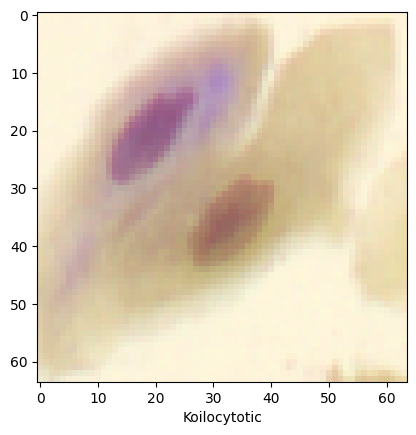

In [ ]:
categories = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]

def show_the_image(i):
    plt.imshow(data[i])
    plt.xlabel(categories[labels[i]])

show_the_image(0)

In [ ]:
# Loading ResNet50 wit imagenet weights, include_top means that we loading model without last fully connected layers
model_resnet       = ResNet50(weights = 'imagenet', include_top = False)
model_densenet     = DenseNet121(weights = 'imagenet', include_top = False)
model_efficientnet = EfficientNetB5(weights = 'imagenet', include_top = False)

features_resnet       = model_resnet.predict(data, batch_size=32)
features_densenet     = model_densenet.predict(data, batch_size=32)
features_efficientnet = model_densenet.predict(data, batch_size=32)

print(features_resnet.shape)
print(features_densenet.shape)
print(features_efficientnet.shape)

127/127 [==============================] - 48s 380ms/step
(4049, 2, 2, 2048)
(4049, 2, 2, 1024)
(4049, 2, 2, 1024)


In [ ]:
extracted_features = []

# for feature, label in zip(features, labels):
#     feature = feature.reshape(32768)
#     feature = np.append(feature, label)
#     extracted_features.append(feature)

# extracted_features = np.array(extracted_features)

# print(extracted_features)


for f_r, f_d, f_e, label in zip(features_resnet, features_densenet, features_efficientnet, labels):
    f_r = f_r.reshape(f_r.shape[0] * f_r.shape[1] * f_r.shape[2])
    f_d = f_d.reshape(f_d.shape[0] * f_d.shape[1] * f_d.shape[2])
    f_e = f_e.reshape(f_e.shape[0] * f_e.shape[1] * f_e.shape[2])

    f_r = np.append(f_r, f_d)
    f_r = np.append(f_r, f_e)
    f_r = np.append(f_r, label)
    extracted_features.append(f_r)

extracted_features = np.array(extracted_features)

print(extracted_features.shape)

(4049, 16385)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [ ]:
# # Normalization :-

X = extracted_features[:, 0:-1]
y = extracted_features[:, -1]

# scaler = StandardScaler()
# scaler.fit(X)
# scaled_X = scaler.transform(X)

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

In [ ]:
# PCA :-

pca = PCA(n_components = 0.95)
pca.fit(scaled_X)
principal_X = pca.transform(scaled_X)

In [ ]:
# Check the values of eigen vectors prodeced by principal components
print(len(pca.components_))

# check how much variance is explained by each principal component

print(pca.explained_variance_ratio_)

1376
[1.58362223e-01 9.56092657e-02 4.11948229e-02 ... 5.54878855e-05
 5.54254227e-05 5.53718589e-05]


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(principal_X, y, test_size = 0.2, random_state = 1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3239, 1376)
(810, 1376)
(3239,)
(810,)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

model = Sequential()

model.add(Flatten(input_shape=(X_train.shape[1], 1)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(5, activation='softmax'))

#Compilation of the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1376)              0         
                                                                 
 dense (Dense)               (None, 256)               352512    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 353797 (1.35 MB)
Trainable params: 353797 (1.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
epochs = 10
nn = model.fit(X_train, y_train, batch_size=32, epochs=epochs)

Epoch 1/10
102/102 [==============================] - 1s 6ms/step - loss: 0.6802 - accuracy: 0.7836
Epoch 2/10
102/102 [==============================] - 1s 6ms/step - loss: 0.1683 - accuracy: 0.9559
Epoch 3/10
102/102 [==============================] - 1s 6ms/step - loss: 0.0768 - accuracy: 0.9864
Epoch 4/10
102/102 [==============================] - 1s 6ms/step - loss: 0.0439 - accuracy: 0.9951
Epoch 5/10
102/102 [==============================] - 1s 6ms/step - loss: 0.0262 - accuracy: 0.9975
Epoch 6/10
102/102 [==============================] - 1s 6ms/step - loss: 0.0182 - accuracy: 0.9994
Epoch 7/10
102/102 [==============================] - 1s 6ms/step - loss: 0.0134 - accuracy: 0.9994
Epoch 8/10
102/102 [==============================] - 1s 6ms/step - loss: 0.0098 - accuracy: 0.9994
Epoch 9/10
102/102 [==============================] - 1s 6ms/step - loss: 0.0073 - accuracy: 1.0000
Epoch 10/10
102/102 [==============================] - 1s 8ms/step - loss: 0.0065 - accuracy: 0.9997

In [ ]:
pred = model.predict(X_test)
y_nn = np.argmax(pred, axis=1)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_nn)
print("Accuracy is: ", acc*100)

26/26 [==============================] - 0s 2ms/step
Accuracy is:  94.44444444444444


array([[ 1.14369908e+01,  8.55930175e+00,  1.63270693e+00, ...,
         2.59636824e-03,  1.06201682e-01,  8.84941549e-02],
       [ 1.02490037e+01,  2.33332463e+00,  2.27644713e-02, ...,
        -1.86662821e-01,  1.39583247e-01, -2.15874977e-01],
       [-1.06801344e+00, -7.21469150e+00,  6.71514214e-01, ...,
         8.91712317e-02,  5.83585900e-02, -7.98491819e-02],
       ...,
       [-3.33913350e+00, -4.81671014e+00, -2.39702613e+00, ...,
        -1.02158264e-01, -2.13601233e-02, -4.20904520e-02],
       [ 4.76142803e+00,  9.99338499e+00,  2.99804924e+00, ...,
         6.96253681e-02,  5.45696495e-02, -1.98513673e-01],
       [-3.75338239e+00,  4.96072556e+00,  2.22900473e+00, ...,
        -1.43300204e-01, -1.04099167e-01,  1.04782519e-01]])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print("Classification Report: \n", classification_report(y_test, y_nn))

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.95      0.96      0.96       167
         1.0       0.91      0.87      0.89       165
         2.0       0.90      0.93      0.92       132
         3.0       0.98      0.98      0.98       174
         4.0       0.97      0.98      0.97       172

    accuracy                           0.94       810
   macro avg       0.94      0.94      0.94       810
weighted avg       0.94      0.94      0.94       810



In [ ]:
model.save('cerival.h5')

In [ ]:
import numpy as np
from keras.models import load_model
from PIL import Image

# Load the saved model
loaded_model = load_model('cerival.h5')

# Assuming 'new_image_path' is the path to your .dat file
new_image_path = '/content/im_Dyskeratotic/im_Dyskeratotic/CROPPED/003_08_nuc.dat'

# Load image data from the .dat file (replace this with your custom loader)
with open(new_image_path, 'rb') as file:
    # Assuming the first two values in the file represent the height and width
    height, width = np.fromfile(file, dtype=np.uint32, count=2)

    # The remaining values are assumed to be the image data
    remaining_data = np.fromfile(file, dtype=np.uint8)

# Calculate the expected size of the image data based on the height, width, and channels
channels = 3  # Assuming RGB color channels
expected_size = height * width * channels

# Check if the size of the remaining data matches the expected size
if remaining_data.size == expected_size:
    # Reshape the data to the desired image dimensions
    image_data = remaining_data.reshape((height, width, channels))

    # Convert numpy array to PIL Image
    new_image = Image.fromarray(image_data, 'RGB')

    # Resize the image to the expected dimensions
    new_size_image = new_image.resize((64, 64))  # Adjust as needed

    # Convert the image to a numpy array
    new_data = np.array(new_size_image)
    new_flat_image = new_data.reshape(1, -1)

    # Scale and apply PCA transformation (similar to what you did during training)
    scaled_new_image = scaler.transform(new_flat_image)  # Assuming 'scaler' is the one used during training
    principal_new_image = pca.transform(scaled_new_image)  # Assuming 'pca' is the one used during training

    # Make predictions using the loaded model
    predictions = loaded_model.predict(principal_new_image)

    # Print the predictions
    print("Predictions:", predictions)
else:
    print("Size of the remaining data does not match the expected size.")


Size of the remaining data does not match the expected size.
